In [2]:
%load_ext autoreload
%autoreload 2

# Setup

In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from deepexperiment.utils import one_hot_encoding, one_hot_encoding_batch, ResBlock, get_indices
from deepexperiment.interpret import DeepShap
from deepexperiment.alignment import Attrament
from deepexperiment.visualization import plot_alignment, plotbar_miRNA_importance

# Loading model and data

Used model is the `miRBind` [[1]](https://github.com/ML-Bioinfo-CEITEC/miRBind) model trained on the `Helwak et al., 2013` [[2]](https://doi.org/10.1016/j.cell.2013.03.043) dataset. Used dataset is from the `miRBind` [[1]](https://github.com/ML-Bioinfo-CEITEC/miRBind) and is constructed from the `Helwak et al., 2013` [[2]](https://doi.org/10.1016/j.cell.2013.03.043) dataset.

In [4]:
model = keras.models.load_model("../models/miRBind.h5")

2022-11-05 11:41:51.653921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
samples = pd.read_csv('../data/test_set_1_1_CLASH2013_paper.tsv', sep='\t')
pos_samples = samples[samples['label'] == 1].reset_index(drop=True)
neg_samples = samples[samples['label'] == 0].reset_index(drop=True)

Looking at index: 0
miRNA: TGAGGTAGTAGGTTGTATAG
gene: ATGTCAACCTACCTACTTCTAAGCACAGGGTATGAAGCTCTCTTTCCACT


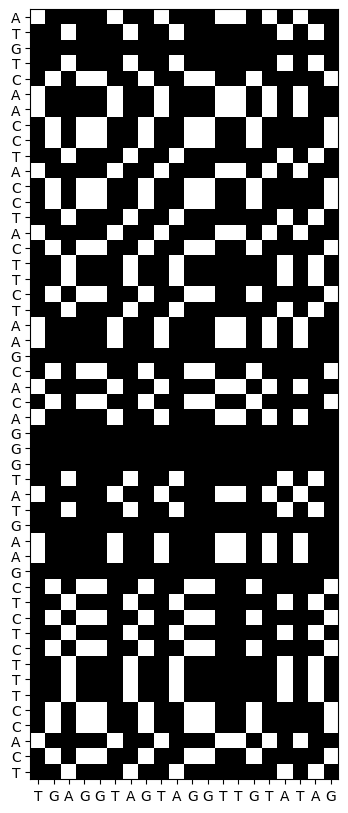

In [21]:
index = 0
print("Looking at index:", index)

miRNA = pos_samples['miRNA'][index]
gene = pos_samples['gene'][index]
data = one_hot_encoding(miRNA, gene)

print("miRNA:", miRNA)
print("gene:", gene)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.imshow(data[0,:,:,0], cmap='gray')
ax.set_xticks(range(len(miRNA)))
ax.set_xticklabels(miRNA)
ax.set_yticks(range(len(gene)))
ax.set_yticklabels(gene)
plt.plot();

# Prediction

Before we will dive into the interpretation of the model, we will first look at the model's prediction on one selected sample and then we will compute precision-recall curve for the whole dataset. It is reasonable to check that model is performing well before we will try to interpret it.

In [22]:
index = 0
print("Looking at index:", index)

miRNA = pos_samples['miRNA'][index]
gene = pos_samples['gene'][index]
data = one_hot_encoding(miRNA, gene)

print("True label:", pos_samples['label'][index])

preds = model.predict(data, verbose=0)
print("Prediction:\n  negative ", preds[0][0], "\n  positive ", preds[0][1])

Looking at index: 0
True label: 1
Prediction:
  negative  0.14746644 
  positive  0.8525336


125/125 [==============================] - 13s 105ms/step
Precision-recall AUC: 0.9672995931996167


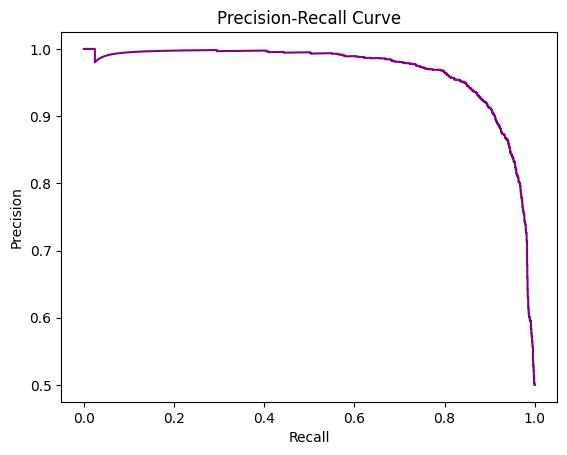

In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

# prepare data for the model
data, labels = one_hot_encoding_batch(samples)

# get predictions
pred = model.predict(data)
pred_label = np.argmax(pred, axis=1)
pred_f = np.zeros(len(pred))
pred_f[pred_label == 1] = pred[pred_label == 1][:, 1]
pred_f[pred_label == 0] = 1 - pred[pred_label == 0][:, 0]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(labels, pred_f)

# calculate precision-recall AUC
print("Precision-recall AUC:", metrics.auc(recall, precision))

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

# DeepSHAP attribution

DeepSHAP [[3]](https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html) is an interpretation technique that builds on top of DeepLIFT [[4]](https://doi.org/10.48550/arXiv.1704.02685) and improves it by using a distribution of background samples instead of a single reference value. This improves the accuracy of the attribution scores, but also increases the computational complexity. The complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly $1/sqrt(N)$ for N background data samples.

Due to computational complexity, we will use a subset of the training data as background samples. We will use 100 samples. Note: you can utilize GPU for faster computation.

In [23]:
rand_samples = pos_samples.sample(n=100, replace=False, random_state=42).reset_index(drop=True)
background, _ = one_hot_encoding_batch(rand_samples)

In [24]:
deepShap = DeepShap(model, background)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [25]:
neg_shap, pos_shap = deepShap(data)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


The attribution scores obtained from the Deep SHAP method produce the map of areas in the input that are positively and negatively contributing to the model’s decision. 

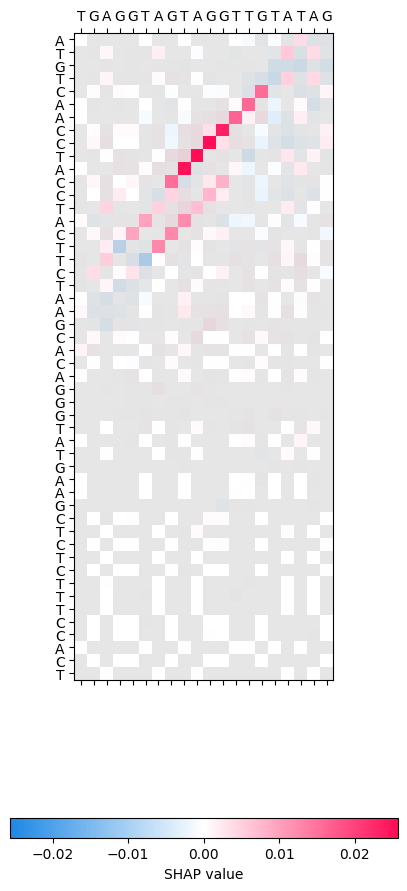

In [34]:
from shap.plots.colors import red_transparent_blue

fig, ax = plt.subplots(1,1, figsize=(5, 12))

abs_vals = np.stack(np.abs(pos_shap.sum(-1)), 0).flatten()
max_val = np.nanpercentile(abs_vals, 99.9)
ax.imshow(data[0,:,:,0], alpha=0.1, cmap='gray')
im = ax.matshow(pos_shap[0,:,:,0], cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)
ax.set_xticks(range(len(miRNA)))
ax.set_xticklabels(miRNA)
ax.set_yticks(range(len(gene)))
ax.set_yticklabels(gene)

cb = plt.colorbar(im, label="SHAP value", orientation="horizontal")

plt.show();

# Attrament

The attrament (attribution sequence alignment) technique is based on the principles of dynamic programming for semi-global sequence alignment computed on top of attribution scores obtained from interpreting the trained neural network by the SHAP method.

In [35]:
attrament = Attrament()
align_x, align_s, align_y = attrament(gene, miRNA[::-1], pos_shap[0,:,:,0])

In [36]:
print(" ".join(align_x))
print(" ".join(align_y))

T C A C C T T T C T C T C G A A G T A T G G G A C A C G A A T C T T C A T C C A T C C A A C T G T A -
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - T G A G G T A - G T A G G T T G T A T A G


# Visualization

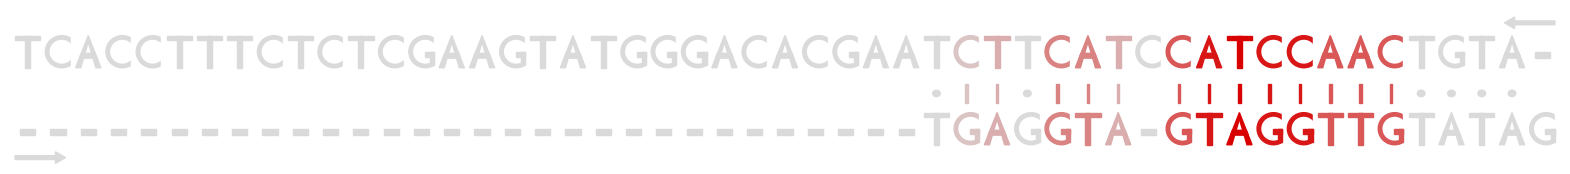

In [39]:
plot_alignment(align_x, align_s, align_y)

FixedFormatter should only be used together with FixedLocator


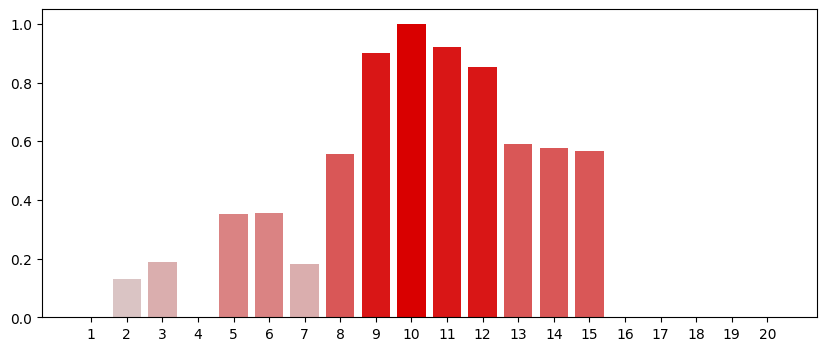

In [41]:
plotbar_miRNA_importance(align_y, align_s)